# 라이브러리

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import json
import datetime
import re

import joblib
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from kmodes.kprototypes import KPrototypes

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:
    rc('font', family='AppleGothic')

# 데이터 불러오기

In [2]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [3]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')
price = call_df('crawling_db.price_table')

In [4]:
df = (apartment.
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left',on='apartment_id'))

# 데이터 전처리

## 변수 생성

### 단위 면적당 최고가(원/$m^2$)
- 단위 면적당 최고가 변수를 클러스터링에 사용합니다. 집단 내 가격의 분산을 줄여주기 위한 변수입니다.

In [5]:
# area(면적) 변수 전처리
price['area'] = price['area'].apply(lambda x: int(re.split('\D',x)[0]))

# unit_price(단위 가격) 변수 생성
price['unit_price'] = round(price['amount']/price['area'])

# 아파트 ID별 최고가 변수 추출 
max_price = price.groupby('apartment_id')['unit_price'].max()

## 데이터 병합

In [6]:
df = (apartment.
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left', on='apartment_id').
      merge(max_price, how='left', on='apartment_id'))

## 숫자형 자료

In [7]:
df['school_students'] = pd.to_numeric(df['school_students'])

In [8]:
print(df.isna().sum())

district_id                 0
apartment_id                0
apartment_addr_town         0
apartment_builder           0
apartment_build_year        0
apartment_build_month       0
apartment_floor_min         0
apartment_floor_max         0
apartment_parking           0
apartment_name              0
district_name               0
school_name                 0
school_dist                 0
school_addr_district        0
school_addr_town            0
school_students           840
st_name                     0
st_dist                     0
st_volume                   0
unit_price               2333
dtype: int64


- 네이버에서 근처에 학교가 없을 경우, 학교가 없다고 인식하여 결측치가 발생합니다. 이를 0으로 대체하겠습니다.
- 거래 기록이 아예 없는 데이터는 단위 가격이 존재하지 않습니다. 이를 0으로 대체하겠습니다.

In [9]:
df['school_students'] = df['school_students'].fillna(0)
df['unit_price'] = df['unit_price'].fillna(0)

### 정규화
- StandardScaler로 정규화합니다.

In [10]:
def standard_scaler_save(data, variable):
    scaler = StandardScaler()
    scaler.fit(data[variable].values.reshape(-1,1))
    joblib.dump(scaler, f'./model/{variable}_scaler.pkl')

def scaling(data, variable):
    scaler = joblib.load(f'./model/{variable}_scaler.pkl')
    output = scaler.transform(data[variable].values.reshape(-1,1))
    return output

def inverse_scaling(data, variable):
    scaler = joblib.load(f'./model/{variable}_scaler.pkl')
    output = scaler.inverse_transform(data[variable].values.reshape(-1,1))
    return output 

In [11]:
numericals = [
    'school_students',
    'st_dist',
    'apartment_parking',
    'unit_price'
    ]

for variable in numericals:
    standard_scaler_save(df, variable)
    df[variable] = scaling(df, variable)

## 범주형 자료

In [12]:
labels = [
    'school_name',
    'apartment_addr_town',
    'st_name'
    ]

categoricals = [
    'district_id',
    'apartment_build_year',
    'school_name',
    'apartment_addr_town',
    'st_name'
    ]

In [13]:
def label_encoder_save(data, var_name):
    encoder = LabelEncoder()
    encoder.fit(data[var_name])
    joblib.dump(encoder, f'./model/{var_name}_encoder.pkl')

def label_encoding(data, variable):
    encoder = joblib.load(f'./model/{variable}_encoder.pkl')
    output = encoder.transform(data[variable])
    return output

def label_decoding(data, variable):
    encoder = joblib.load(f'./model/{variable}_encoder.pkl')
    output = encoder.inverse_transform(data[variable])
    return output

In [14]:
for variable in labels:
    label_encoder_save(df, variable)
    df[variable] = label_encoding(df, variable)

# Modeling 

## K-Prototypes Clustering

In [15]:
train = df[categoricals + numericals].copy()
print(len(categoricals))

5


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8016 entries, 0 to 8015
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_id           8016 non-null   int64  
 1   apartment_build_year  8016 non-null   int64  
 2   school_name           8016 non-null   int32  
 3   apartment_addr_town   8016 non-null   int32  
 4   st_name               8016 non-null   int32  
 5   school_students       8016 non-null   float64
 6   st_dist               8016 non-null   float64
 7   apartment_parking     8016 non-null   float64
 8   unit_price            8016 non-null   float64
dtypes: float64(4), int32(3), int64(2)
memory usage: 532.3 KB


In [17]:
pseudo_k = range(1,21)
cost = []
for i in tqdm(pseudo_k):
    kproto = KPrototypes(n_clusters=i, verbose=0, init='Cao', random_state=0, n_jobs=-1)
    kproto.fit_predict(train, categorical=list(range(len(categoricals))))
    cost.append(kproto.cost_)
cost_table = pd.DataFrame({'k':pseudo_k, 'cost':cost})

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:56<00:00, 26.82s/it]


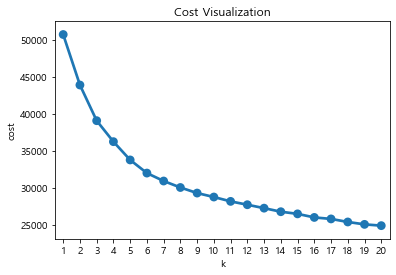

In [18]:
def cost_visualize(data, x, y):
    sns.pointplot(data=data, x=x, y=y)
    plt.title('Cost Visualization')
    plt.show()
cost_visualize(cost_table, 'k', 'cost')

- 적당한 k를 찾기 위해 Elbow Method를 사용합니다. Cost가 줄어드는 비율이 확연하게 줄어드는 지점이 유의미한 k라고 가정합니다. 위의 Cost 시각화 그래프에서 기울기의 변동 비율이 0.1 이하로 떨어지며 클러스터 수가 작은 값을 적당한 k라고 정의하겠습니다.

In [19]:
cost_table['coef'] = abs(cost_table['cost'] - cost_table['cost'].shift(1))
cost_table['ratio'] =  abs((cost_table['coef'].shift(1) - cost_table['coef'])/cost_table['coef'])
optimal_k = cost_table.loc[cost_table['ratio'] <= 0.1]['k'].min()
print(f'가장 적당한 k는 {optimal_k}입니다.')

가장 적당한 k는 11입니다.


In [20]:
kproto = KPrototypes(n_clusters=optimal_k, verbose=0, random_state=0, n_jobs=-1)
train['cluster'] = kproto.fit_predict(train, categorical=list(range(len(categoricals))))

## Saving as Pickle

In [21]:
train['apartment_id'] = df['apartment_id']
output = train[['apartment_id','cluster']].sort_values('apartment_id').reset_index(drop=True)
output.to_pickle('./data/clustered_apartment.pkl')